<a href="https://colab.research.google.com/github/freyaldi/ML/blob/main/food_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roadmap
1. Convolution Layer
2. Max Pooling
3. 1 Hidden Layer Consist of 100 Neurons ReLu
4. Output Layer 2 Neurons, Softmax activiton function



## Import Required Libraries

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
# from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

##Download The Inception V3 Weights

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-05-18 18:15:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  89.7MB/s    in 0.9s    

2023-05-18 18:15:14 (89.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

##Pre-trained Model Function

In [4]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (256, 256, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [5]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

##Pipelining the pre-trained model with our own layers architecture

In [6]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [7]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 14, 14, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


## Final Food Classification Model

In [8]:
def create_final_model(pre_trained_model, last_output):
  
  x = tf.keras.layers.Conv2D(128, 2, activation='relu')(last_output)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Conv2D(256, 5, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(10, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  return model

## CallBack Function

In [9]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') >= 0.99):   
          self.model.stop_training = True

## Image Data Generator

In [14]:
def generators(DATA_DIR):

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     brightness_range=[0.5, 1.5],
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest',
                                     validation_split=0.3)
  
  val_datagen = ImageDataGenerator(rescale=1./255)

  ##rotation range until fill_mode values were still placeholder

  train_generator = train_datagen.flow_from_directory(directory=DATA_DIR,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=(256, 256),
                                                      subset='training')
  
  val_generator = train_datagen.flow_from_directory(directory=DATA_DIR,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=(256, 256),
                                                  subset='validation')
  
  return train_generator, val_generator

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# TRAIN_DIR='/content/drive/MyDrive/Capstone Project/DATASET/BALANCED/RATIO : 0.8/TRAINING'
# VAL_DIR='/content/drive/MyDrive/Capstone Project/DATASET/BALANCED/RATIO : 0.8/VALIDATION'
DATA_DIR = '/content/drive/MyDrive/download'

# Test the generators
train_generator, val_generator = generators(DATA_DIR)

Found 557 images belonging to 10 classes.
Found 234 images belonging to 10 classes.


## Train Model

In [16]:
model = create_final_model(pre_trained_model, last_output)
history = model.fit(train_generator, epochs=40, verbose=1, validation_data=val_generator, callbacks=[Callback()])

Epoch 1/40
28/28 [==============================] - 279s 9s/step - loss: 2.1462 - accuracy: 0.2460 - val_loss: 1.2548 - val_accuracy: 0.6624
Epoch 2/40
28/28 [==============================] - 17s 596ms/step - loss: 1.0979 - accuracy: 0.6607 - val_loss: 0.8085 - val_accuracy: 0.7179
Epoch 3/40
28/28 [==============================] - 17s 616ms/step - loss: 0.6742 - accuracy: 0.8043 - val_loss: 0.5467 - val_accuracy: 0.8248
Epoch 4/40
28/28 [==============================] - 17s 598ms/step - loss: 0.4907 - accuracy: 0.8618 - val_loss: 0.3951 - val_accuracy: 0.9017
Epoch 5/40
28/28 [==============================] - 17s 604ms/step - loss: 0.3638 - accuracy: 0.8869 - val_loss: 0.2761 - val_accuracy: 0.9274
Epoch 6/40
28/28 [==============================] - 17s 626ms/step - loss: 0.2735 - accuracy: 0.9066 - val_loss: 0.2959 - val_accuracy: 0.9103
Epoch 7/40
28/28 [==============================] - 17s 599ms/step - loss: 0.2704 - accuracy: 0.9318 - val_loss: 0.2200 - val_accuracy: 0.9188
E

## Visualization

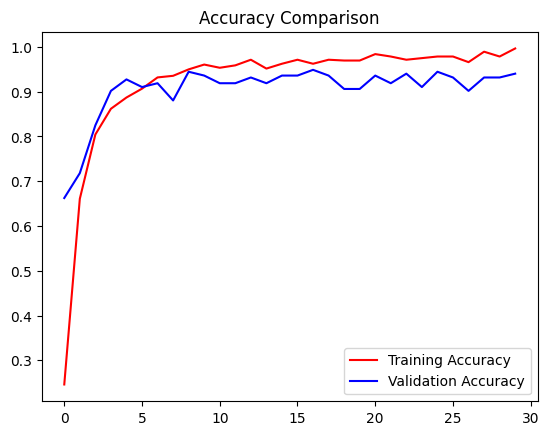

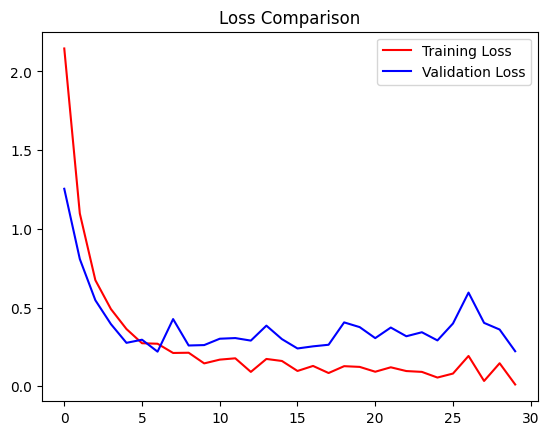

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()
plt.figure()
print('')


plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()

## Testing Code

Saving 54_bonang.jpg to 54_bonang.jpg
1/1 [==============================] - 0s 24ms/step
54_bonang.jpg
Bonang
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


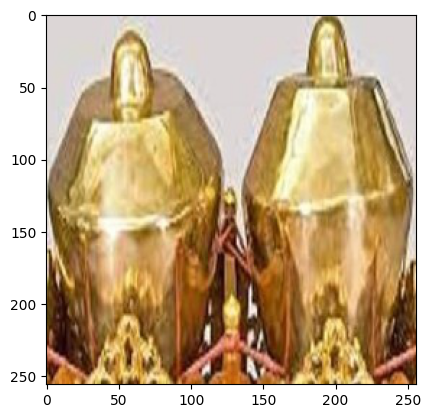

In [56]:
from tensorflow.keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (256, 256))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  if classes[0][0] == 1:
    print("Bonang")
  elif classes[0][1] == 1:
    print("Burdah")
  elif classes[0][2] == 1:
    print("Kolintang")
  elif classes[0][3] == 1:
    print("Rebab")
  elif classes[0][4] == 1:
    print("Saluang")
  elif classes[0][5] == 1:
    print("Sape")
  elif classes[0][6] == 1:
    print("Sasando")
  elif classes[0][7] == 1:
    print("Talindo")
  elif classes[0][8] == 1:
    print("Tifa")
  elif classes[0][9] == 1:
    print("Yi")
  else:
    print("Unknown Image or Image Not Valid")

  print(classes[0])

## Load the Model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/C22-PS335: Capstone Project/DATASET/my_model')

loaded_model.summary()

In [ ]:
print(loaded_model.trainable_variables)

## Save The Model

In [57]:
model.save('/content/drive/MyDrive/download/my_model')
model.save_weights('/content/drive/MyDrive/download/my_weight')

tf.saved_model.save(
  model, '/content/drive/MyDrive/download/my_model/my_model_saved_model')

## Convert Saved Model to TF-Lite

In [58]:
# Select mode of optimization
mode = "balanced" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [59]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
export_dir = '/content/drive/MyDrive/download/my_model'
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [60]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/download/nusatala.tflite')
tflite_model_file.write_bytes(tflite_model)

10636096